# IMPORT LIBRARY

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn import preprocessing, metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import RepeatVector,TimeDistributed
from numpy import array
from keras.models import Sequential, load_model
#import utils_paths
import re
from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# CODE

In [2]:
train_sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
submission_file = pd.read_csv('sample_submission.csv')

In [3]:
num = 30490 # number of traindata

In [4]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [5]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T, index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)

In [6]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date']>= '2016-1-27']  #reduce memory
calendar= transform(calendar)
# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T,
                            index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'])
transfer_cal

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144
event_name_1,16,16,16,16,16,16,16,16,16,16,16,14,16,16,2,16,16,16,15,10,16,3,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,4,16,16,7,16,16,16,16,12,16,16,16,16,16,16,16,16,16,16,16,6
event_type_1,4,4,4,4,4,4,4,4,4,4,4,3,4,4,2,4,4,4,0,1,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,4,4,3,4,4,4,4,2,4,4,4,4,4,4,4,4,4,4,4,3
event_name_2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
event_type_2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
snap_CA,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
snap_TX,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,...,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0
snap_WI,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,...,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0


In [7]:
price_fea = calendar[['wm_yr_wk','date']].merge(sell_prices, on = ['wm_yr_wk'], how = 'left')
price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
df = price_fea.pivot('id','date','sell_price')

In [8]:
price_df = train_sales.merge(df,on=['id'],how= 'left').iloc[:,-145:]
price_df.index = train_sales.id
price_df.head()

,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,...,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,...,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
HOBBIES_1_002_CA_1_validation,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOBBIES_1_003_CA_1_validation,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,...,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97
HOBBIES_1_004_CA_1_validation,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,...,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64
HOBBIES_1_005_CA_1_validation,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88


## PREPARING TIME SERIES

In [9]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = train_sales[time_series_columns]  #Get time series data

(28,)


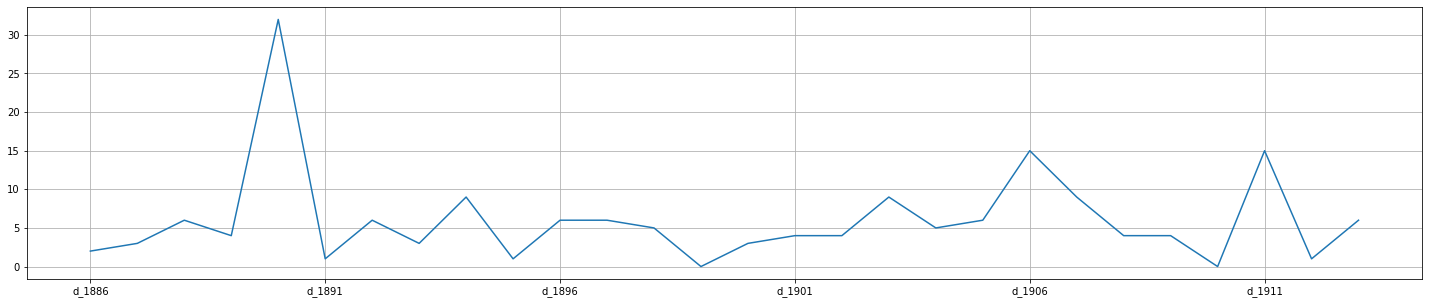

In [10]:
#show last 28days
figsize = (25, 5)
time_series_data.iloc[15, -28:].plot(figsize=figsize)

plt.grid()
#The last 28 days
print(time_series_data.iloc[0, 1885:].shape)

In [11]:
def min_max(df):
    return (df-df.mean())/df.std()  #scale

In [12]:
calendar = pd.read_csv('calendar.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


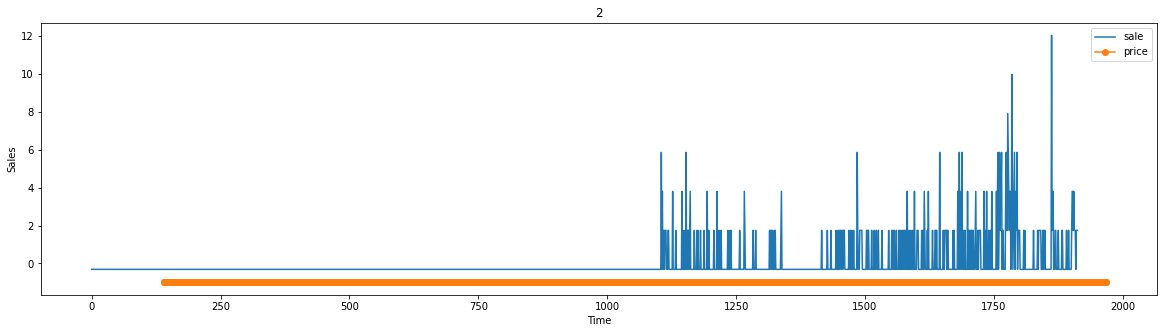

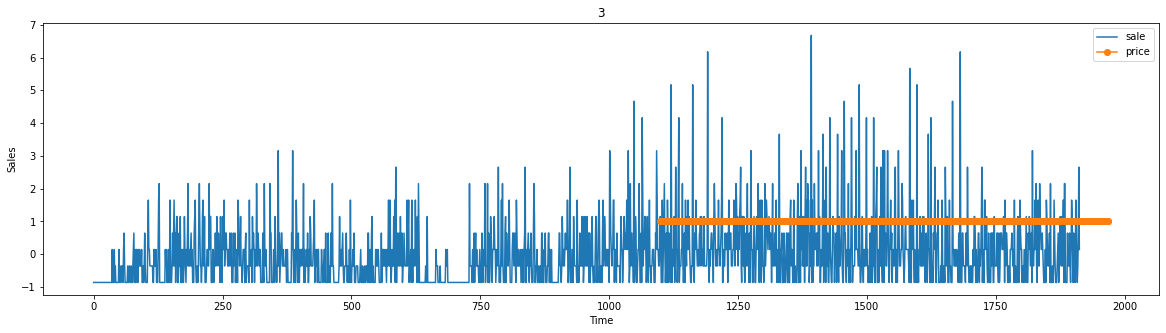

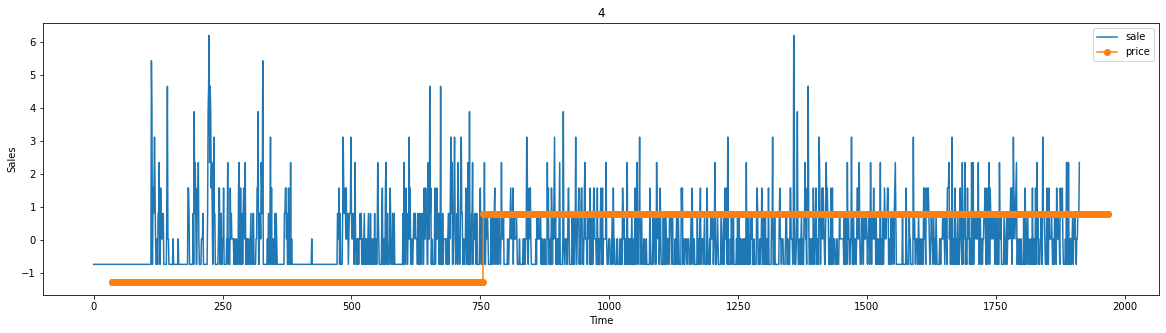

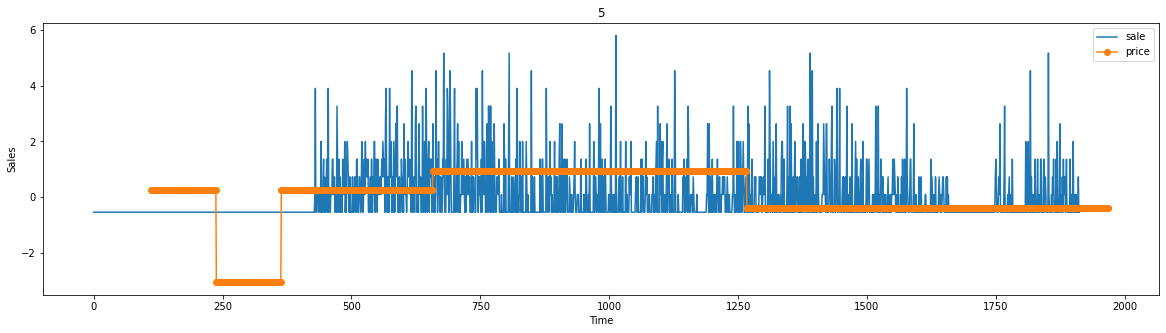

In [13]:
for i in range(2,6):
    price_sell = calendar.merge(sell_prices[sell_prices.item_id=='HOBBIES_1_00'+str(i)][sell_prices.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(min_max(time_series_data.iloc[i].values))
    ax.plot(min_max(price_sell.sell_price),'-o')
    plt.legend(['sale','price'])
    ax.set_title(str(i))
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

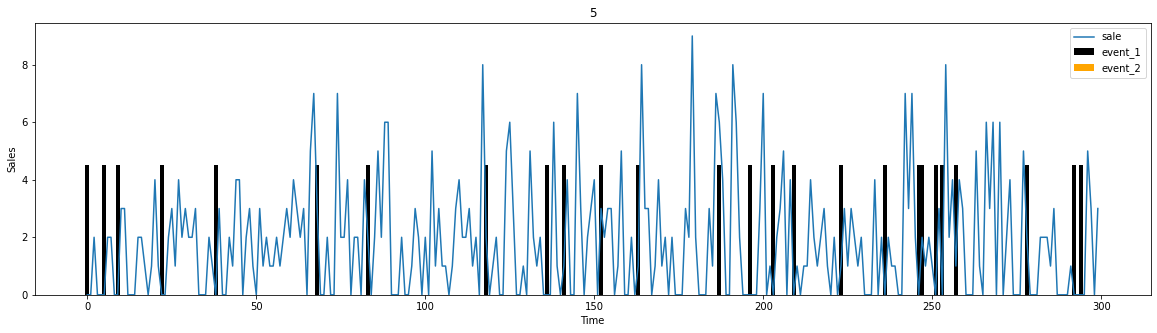

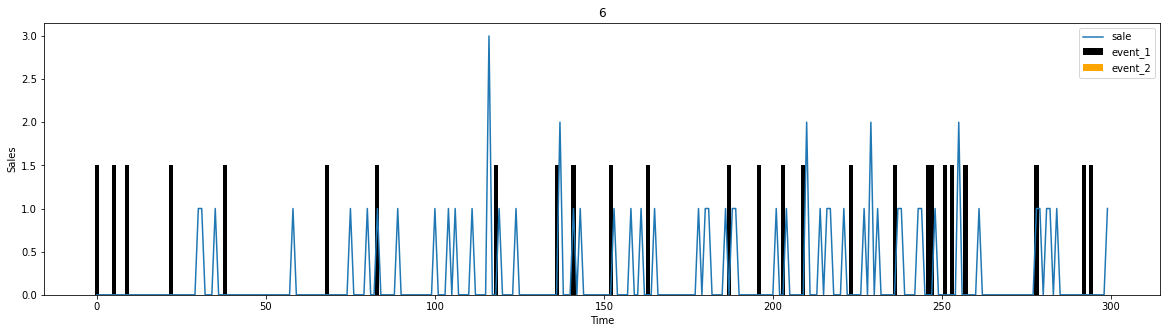

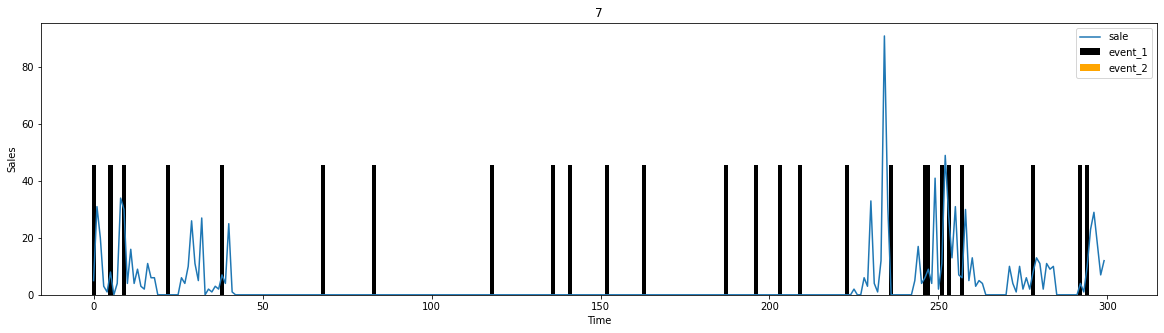

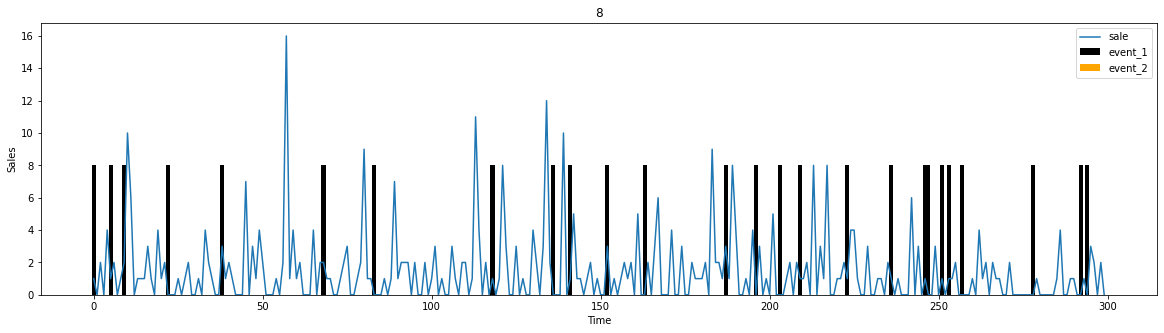

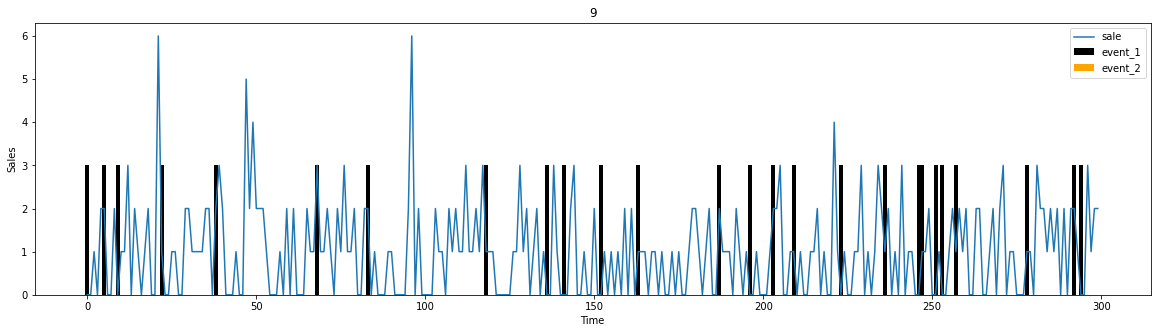

In [14]:
for i in range(5,10):
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    #ax.bar(x = range(len(transfer_cal.loc['snap_WI'][1500:1800].values)),height = transfer_cal.loc['snap_TX'][1500:1800].values,label='snap_TX',facecolor='red')
    ax.plot(time_series_data.iloc[i, 500:800].values,label='sales')
    ax.bar(x = range(300),height = event_name_1_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_1',facecolor='black',width=1.2)
    ax.bar(x = range(300),height = event_name_2_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_2',facecolor='orange',width=1.2)
    plt.legend(['sale','event_1','event_2'])
    ax.set_title(str(i))

    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

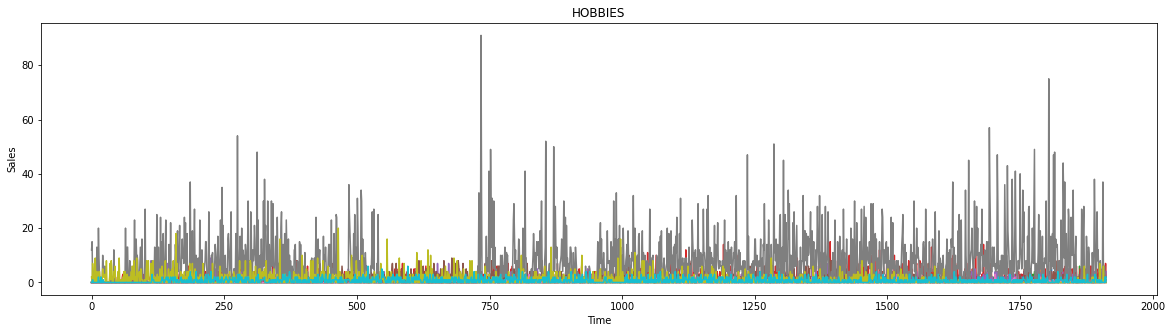

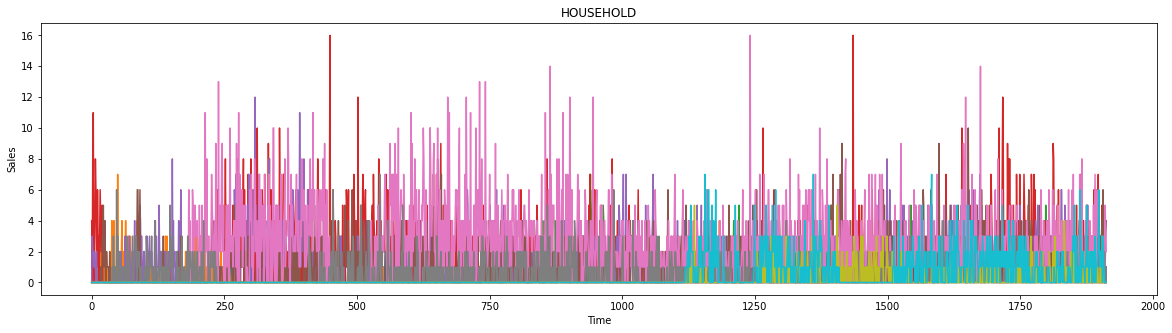

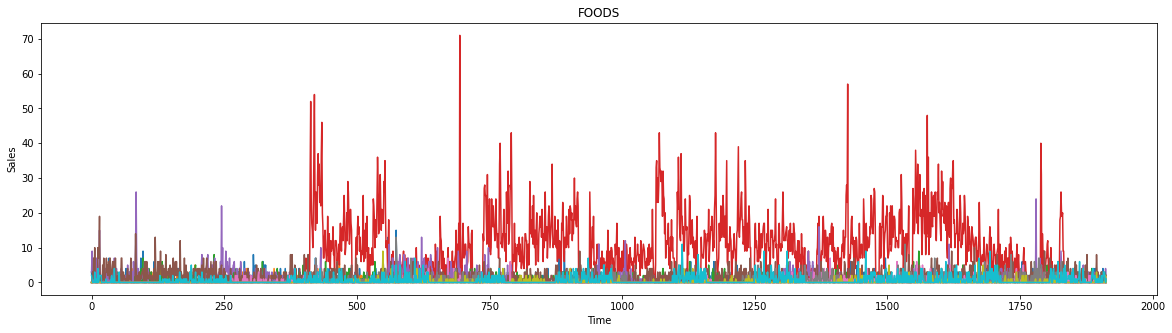

In [15]:
for i in train_sales.cat_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.cat_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

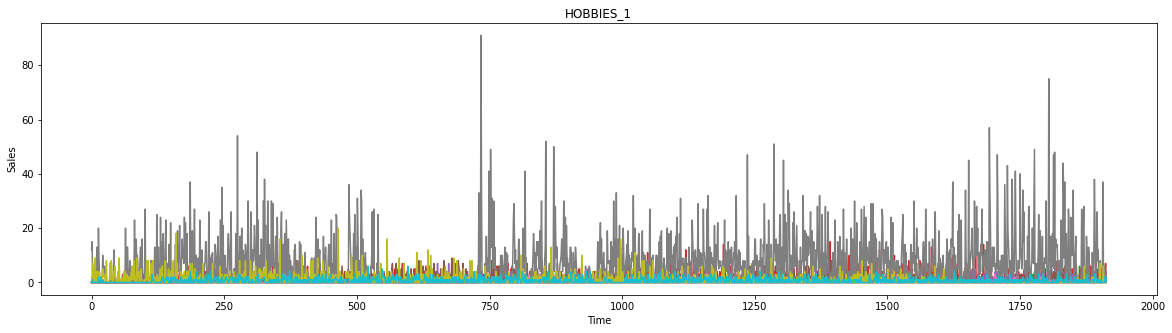

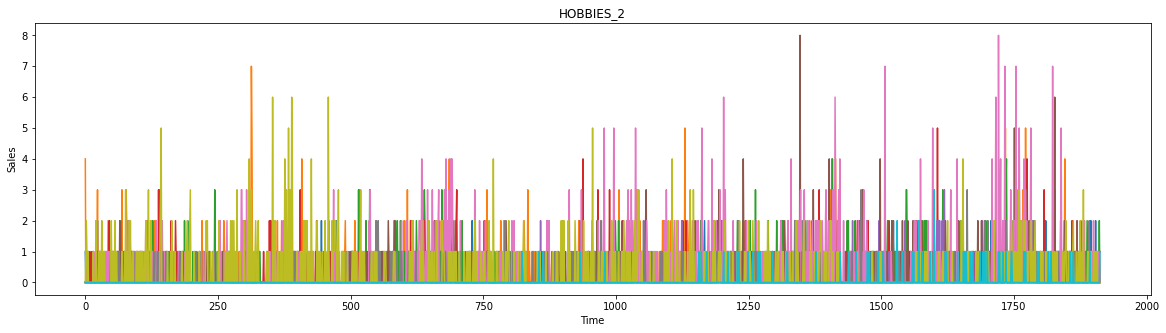

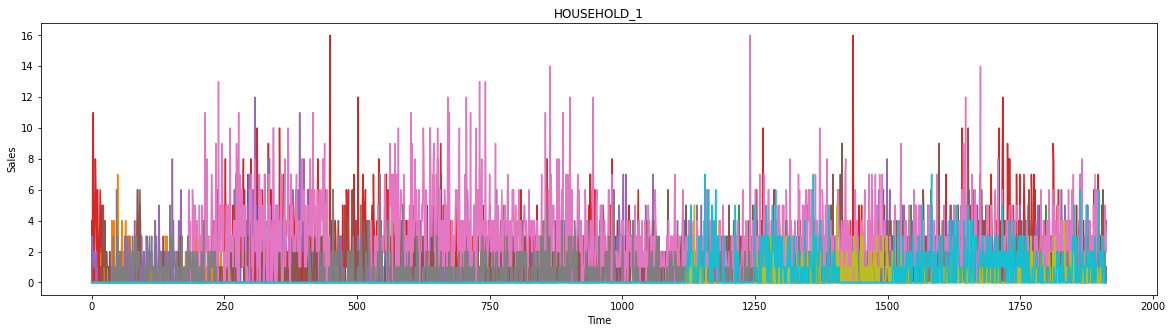

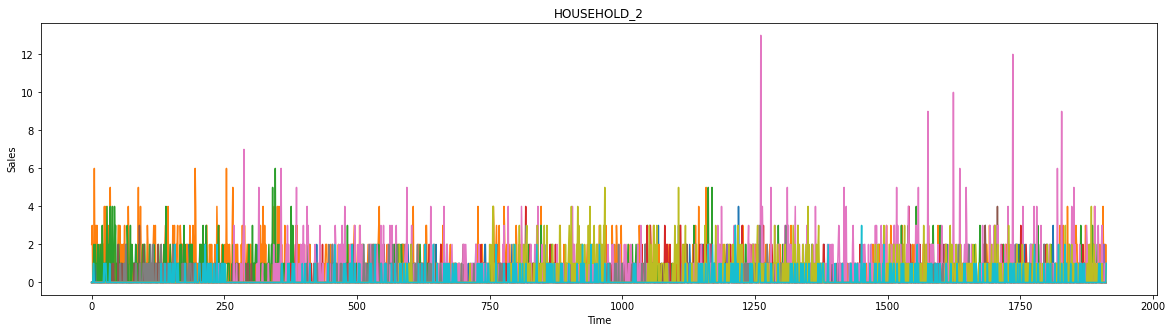

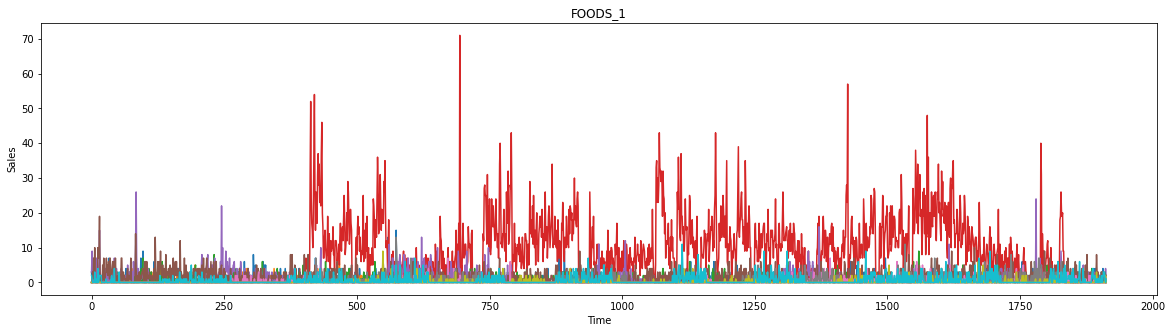

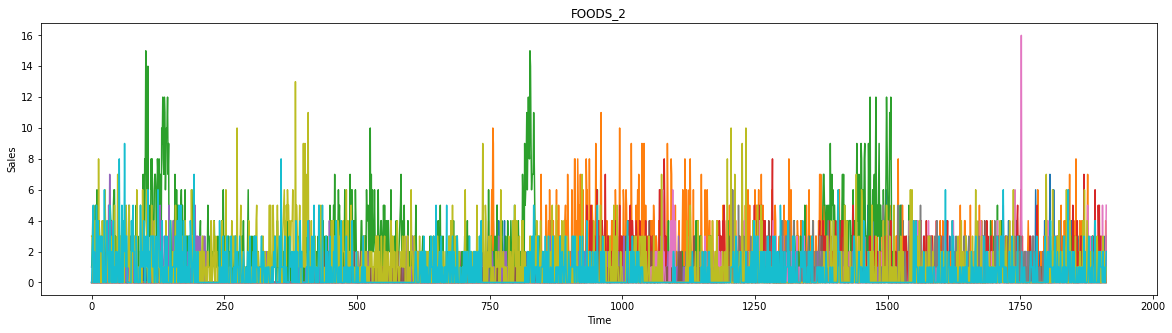

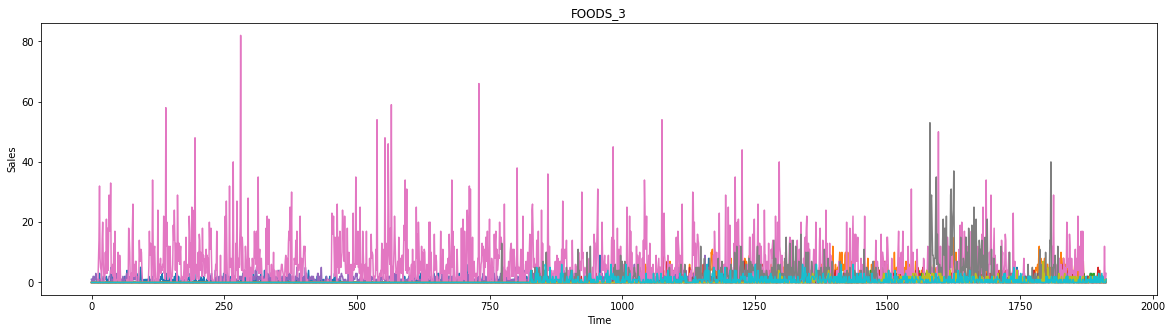

In [16]:
for i in train_sales.dept_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.dept_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

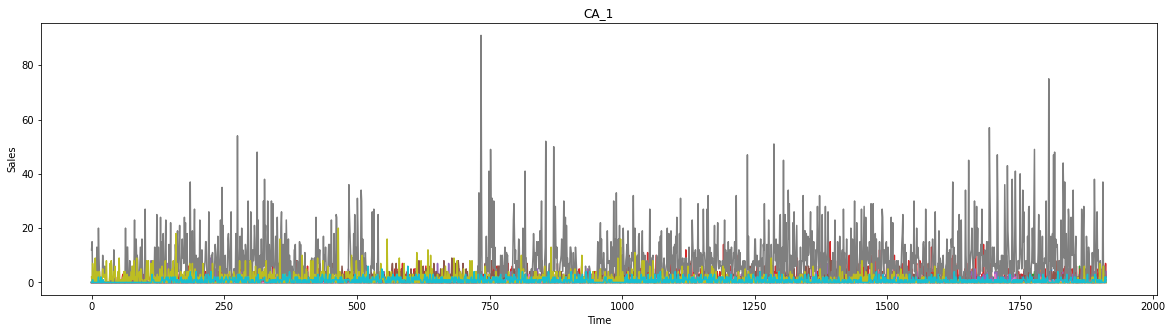

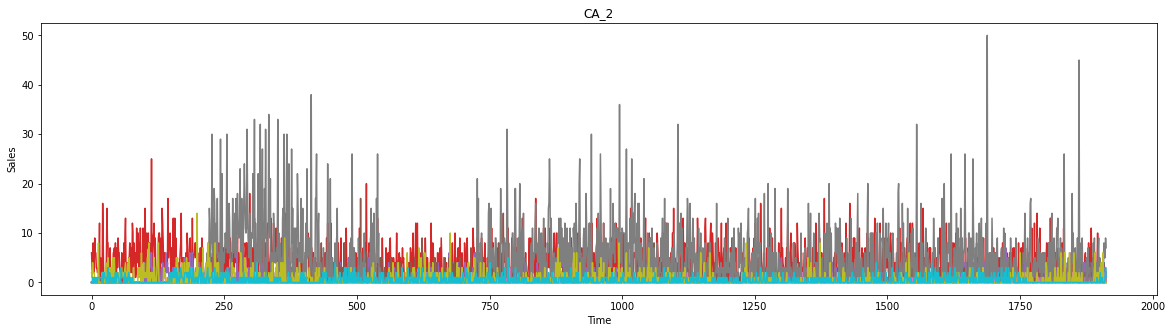

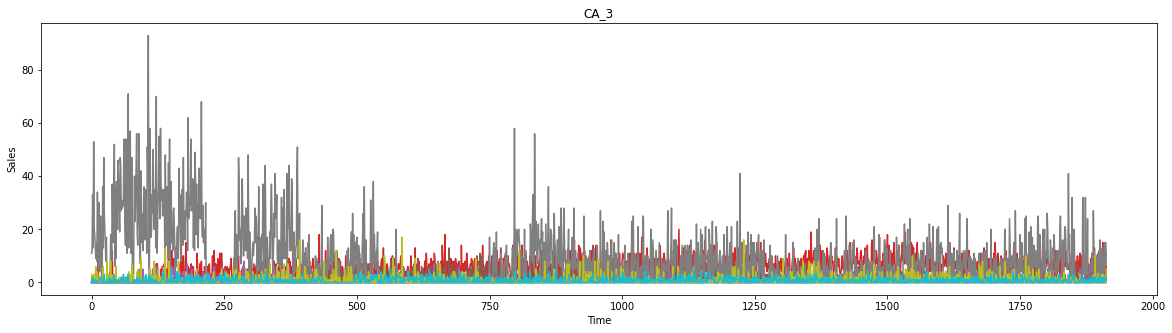

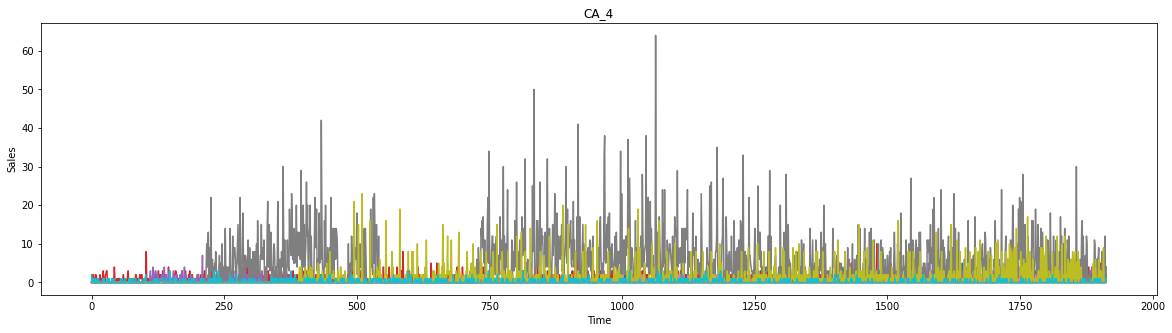

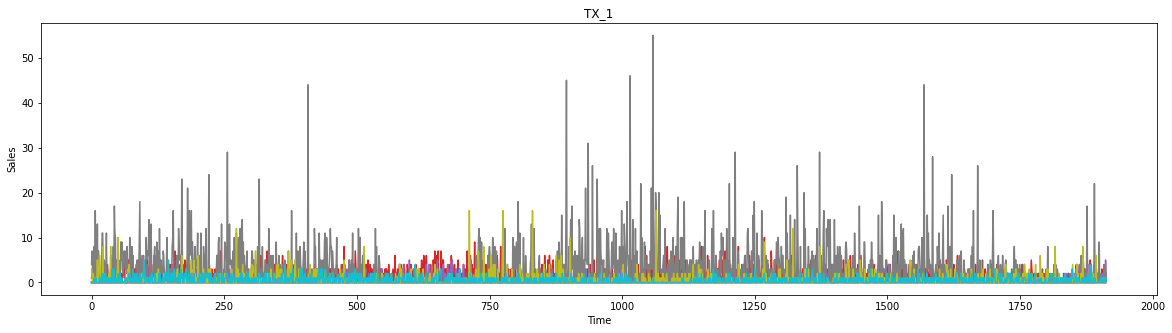

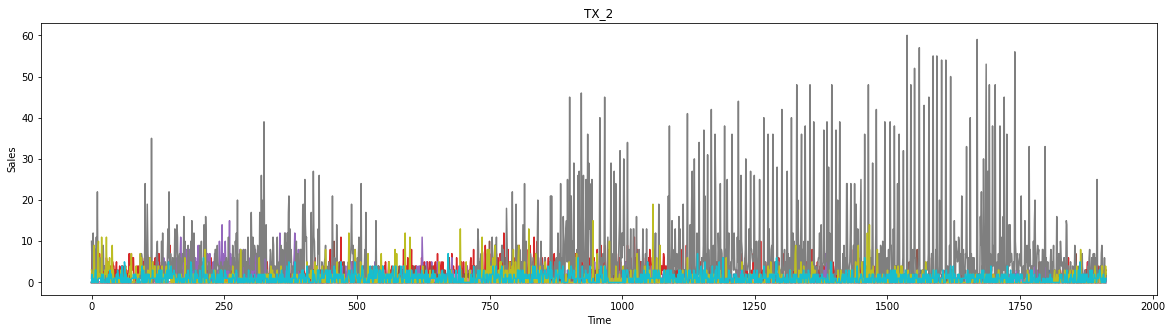

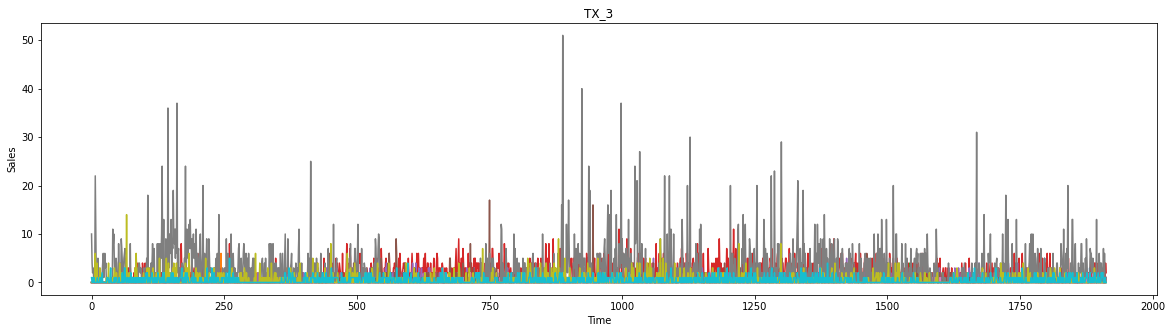

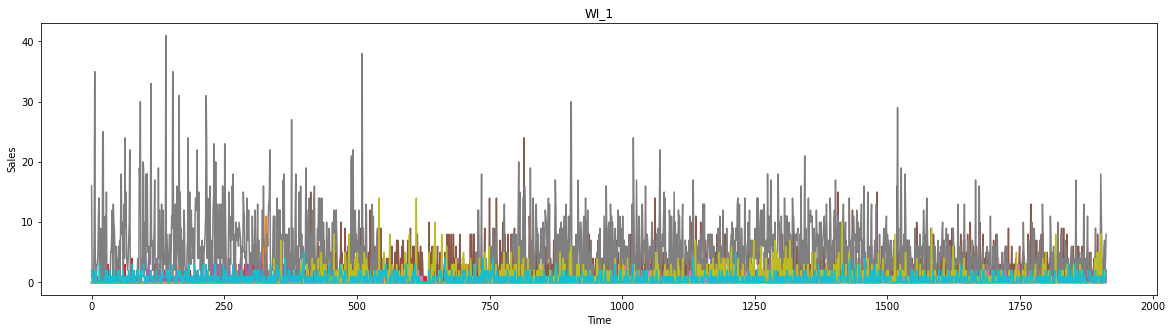

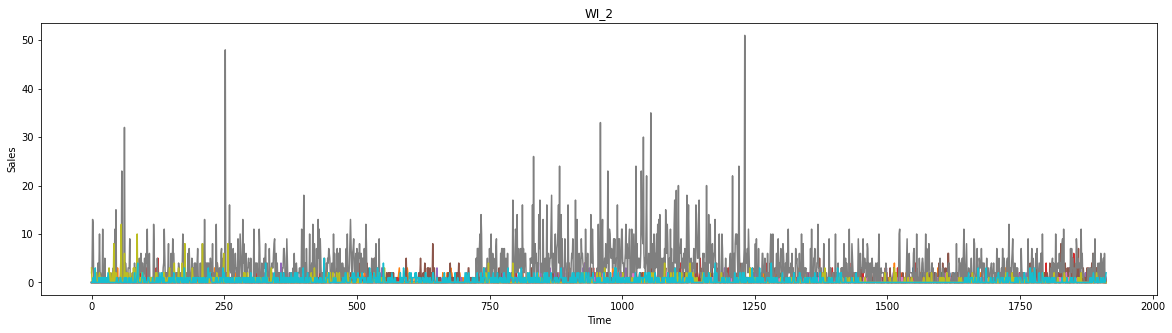

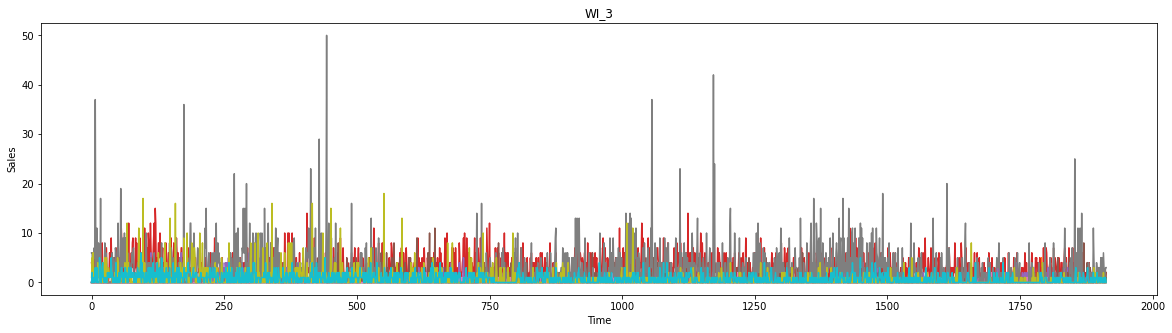

In [17]:
for i in train_sales.store_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.store_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

## BUILD LSTM

In [18]:
X = []   #build a data with two features(salse and event1)
for i in tqdm(range(time_series_data.shape[0])):
    X.append([list(t) for t in zip(transfer_cal.loc['event_name_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_type_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_name_2'][-(100+28):-(28)],     #emmmm.....Those features didn't work for me...
                                   transfer_cal.loc['event_type_2'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_CA'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_TX'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_WI'][-(100+28):-(28)],
                                   price_df.iloc[i][-(100+28):-(28)],
                                   time_series_data.iloc[i][-100:])]) 

X = np.asarray(X, dtype=np.float32)

100%|██████████| 30490/30490 [01:12<00:00, 419.89it/s]


In [19]:
def Normalize(list):
    list = np.array(list)
    low, high = np.percentile(list, [0, 100])
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high

def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list

def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list

In [20]:
np.random.seed(7)

 ## I only use the last 56 days for train_data.
if __name__ == '__main__':
    n_steps = 28
    train_n,train_low,train_high = Normalize(X[:,-(n_steps*2):,:])
    X_train = train_n[:,-28*2:-28,:]
    y = train_n[:,-28:,8]  #     
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 9
    n_out_seq_length =28
    num_y = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    print(X_train.shape)
    # define model

    model = Sequential()

    
    model.add(LSTM(128, activation='relu', input_shape=(28, n_features),return_sequences=False))
    model.add(RepeatVector(n_out_seq_length))
    model.add(LSTM(32, activation='relu',return_sequences=True))
   #model.add(Dropout(0.1))  
    model.add(TimeDistributed(Dense(num_y)))   # num_y means the shape of y,in some problem(like translate), it can be many.
                                                #In that case, you should set the  activation= 'softmax'
    model.compile(optimizer='adam', loss='mse')
    # demonstrate prediction
    model.fit(X_train, y, epochs=10, batch_size=1000)

(30490, 28, 9)
Epoch 1/10
31/31 [==============================] - 9s 172ms/step - loss: 1.6726e-04
Epoch 2/10
31/31 [==============================] - 5s 170ms/step - loss: 8.8716e-05
Epoch 3/10
31/31 [==============================] - 5s 171ms/step - loss: 8.2017e-05
Epoch 4/10
31/31 [==============================] - 5s 168ms/step - loss: 8.0510e-05
Epoch 5/10
31/31 [==============================] - 5s 168ms/step - loss: 8.0044e-05
Epoch 6/10
31/31 [==============================] - 5s 168ms/step - loss: 8.0113e-05
Epoch 7/10
31/31 [==============================] - 5s 167ms/step - loss: 7.9479e-05
Epoch 8/10
31/31 [==============================] - 5s 173ms/step - loss: 7.9656e-05
Epoch 9/10
31/31 [==============================] - 5s 167ms/step - loss: 7.8894e-05
Epoch 10/10
31/31 [==============================] - 5s 169ms/step - loss: 7.9431e-05


In [21]:
x_input = array(X_train[:,-n_steps*1:])
x_input = x_input.reshape((num, n_steps*1, n_features))
print(x_input.shape)
#x_input = Normalize2(x_input,train_low,train_high)
yhat = model.predict(x_input[:,-n_steps:], verbose=0)
x_input=np.concatenate((x_input[:,:,8].reshape(x_input.shape[0],x_input.shape[1]),yhat.astype(np.float32).reshape(x_input.shape[0],x_input.shape[1])),axis=1).reshape((x_input.shape[0],x_input.shape[1]+28,1))
#print(yhat)
print(x_input.shape)

(30490, 28, 9)
(30490, 56, 1)


In [22]:
x_input = FNoramlize(x_input,train_low,train_high)
x_input = np.rint(x_input)

In [23]:
forecast = pd.DataFrame(x_input.reshape(x_input.shape[0],x_input.shape[1])).iloc[:,-28:]
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast[forecast < 0] =0
forecast.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
validation_ids = train_sales['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]

In [25]:
ids = np.concatenate([validation_ids, evaluation_ids])

In [26]:
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast]*2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)